# Wine Clustering and Classification

This project analyzes a dataset from kaggle about wine classification. The dataset I'm using is (Aeberhard & Forina, 1991). It contains different types of information about wine and it has already been classified into 3 varieties. My goal is to see whether these 3 classes are good enough. It may be possible that 2 of these classes are similar enough that they can be merged into one. It may also be the case that there is enough variation within a class that we may need to separate them further.

I am going to use clustering to accomplish this. If the number of clusters matches the number of labels, I may even compare it with supervised models.

The dataset used here has 177 entries and here are the columns:
* Alcohol
* Malic acid
* Ash
* Alcalinity of ash
* Magnesium
* Total phenols
* Flavanoids
* Nonflavanoid phenols
* Proanthocyanins
* Color intensity
* Hue
* OD280/OD315 of diluted wines
* Proline


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore') 

## Exploratory Data Analysis

Let's load the dataset into pandas and see the what the fields are like.

In [2]:
df = pd.read_csv('data/wine.data')
df.head()

,1,14.23,1.71,2.43,15.6,127,2.8,3.06,.28,2.29,5.64,1.04,3.92,1065
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


The column names aren't very easy to understand, so let's change that.

In [3]:
df.columns = ['class',
              'alcohol',
              'malicAcid',
              'ash',
              'ashalcalinity',
              'magnesium',
              'totalPhenols',
              'flavanoids',
              'nonFlavanoidPhenols',
              'proanthocyanins',
              'colorIntensity',
              'hue',
              'od280_od315',
              'proline'
             ]

df.head()

,class,alcohol,malicAcid,ash,ashalcalinity,magnesium,totalPhenols,flavanoids,nonFlavanoidPhenols,proanthocyanins,colorIntensity,hue,od280_od315,proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


That's better. Let's also check if there are any null values. It'll also be useful to know what format the data is in and whether there will need to be any conversion needed.

In [4]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   class                177 non-null    int64  
 1   alcohol              177 non-null    float64
 2   malicAcid            177 non-null    float64
 3   ash                  177 non-null    float64
 4   ashalcalinity        177 non-null    float64
 5   magnesium            177 non-null    int64  
 6   totalPhenols         177 non-null    float64
 7   flavanoids           177 non-null    float64
 8   nonFlavanoidPhenols  177 non-null    float64
 9   proanthocyanins      177 non-null    float64
 10  colorIntensity       177 non-null    float64
 11  hue                  177 non-null    float64
 12  od280_od315          177 non-null    float64
 13  proline              177 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.5 KB


,class,alcohol,malicAcid,ash,ashalcalinity,magnesium,totalPhenols,flavanoids,nonFlavanoidPhenols,proanthocyanins,colorIntensity,hue,od280_od315,proline
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,1.943503,12.993672,2.339887,2.366158,19.516949,99.587571,2.292260,2.023446,0.362316,1.586949,5.054802,0.956983,2.604294,745.096045
std,0.773991,0.808808,1.119314,0.275080,3.336071,14.174018,0.626465,0.998658,0.124653,0.571545,2.324446,0.229135,0.705103,314.884046
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.360000,1.600000,2.210000,17.200000,88.000000,1.740000,1.200000,0.270000,1.250000,3.210000,0.780000,1.930000,500.000000
50%,2.000000,13.050000,1.870000,2.360000,19.500000,98.000000,2.350000,2.130000,0.340000,1.550000,4.680000,0.960000,2.780000,672.000000
75%,3.000000,13.670000,3.100000,2.560000,21.500000,107.000000,2.800000,2.860000,0.440000,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


That's nice. Since all of the features are numeric, this is easy to work with. It might also be useful to know the distribution of the features. So let's look at that.

(-10.0, 40.0)

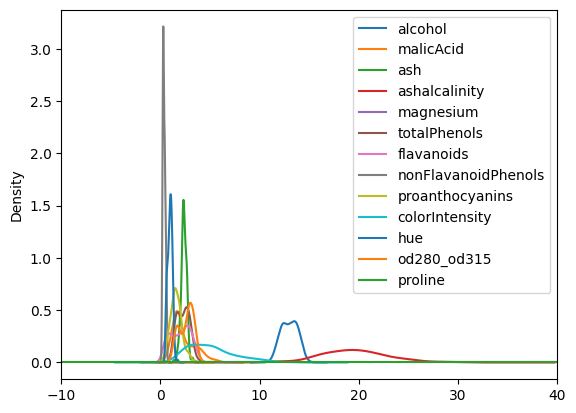

In [5]:
df.drop(columns = ['class']).plot.kde()
plt.xlim(-10, 40)

Let's also look at how many entries exist in each wine class.

<Axes: xlabel='class'>

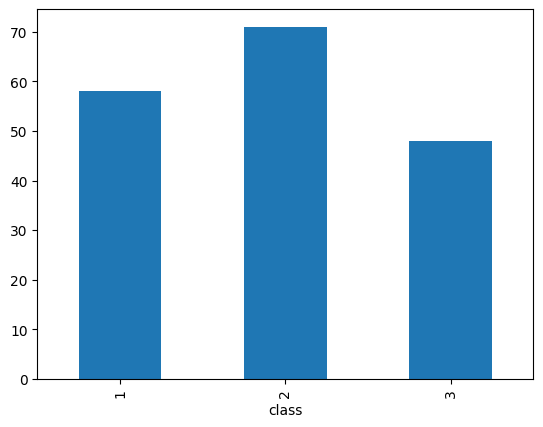

In [6]:
df.groupby('class').size().plot(kind='bar')

Since the data is balanced, let us remove the class names as we won't need it for clustering.

In [7]:
X = df.drop(columns = ['class'])
y = df['class']

X.head()

,alcohol,malicAcid,ash,ashalcalinity,magnesium,totalPhenols,flavanoids,nonFlavanoidPhenols,proanthocyanins,colorIntensity,hue,od280_od315,proline
0,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## Dimensionality Reduction (PCA)

Since there are a lot of features, I'm going to reduce them using Principal Component Analysis. To me, this seems like the best way to reduce dimensions. Since there may be two features that are correlated but both contribute in their own way. By maximizing the variance rather than removing features entirely, you can make sure every feature contributes just the right amount.

Rather than by the number of components, I'm going to reduce them to fit an explained variance ratio. The below code reduces the data to just enough components so that the explained variance ratio is at least 90%.

In [8]:
# Perform PCA
pca = PCA(n_components=0.9).fit(X)
print(pca.n_components_)
print(pca.explained_variance_ratio_)

# Create reduced dataset
X_transformed = pca.transform(X)

1
[0.99810743]


That is interesting. It appears that just one componant is more than enough, with an explained variance ratio of 99.8%. Let us proceed further with this. However, I'll also be testing the same with the full model to see if there is any difference.

## Clustering

It's time to cluster the data and see if the number of efficient clusters match the number of classes.

### Selecting Number of Clusters

Below is the code to cluster the data usinge k-means clustering. I am going to try many different values for the number of clusters on the transformed dataset and see how many clusters to keep depending on the inertia.

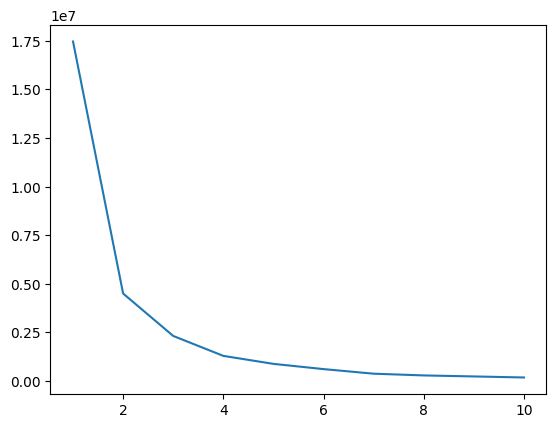

In [9]:
# Metric to see how many clusters to use
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X_transformed)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.show()

It appears the best number of clusters is 3, which matches the number of classes. Let us see if this is the same for the full dataset.

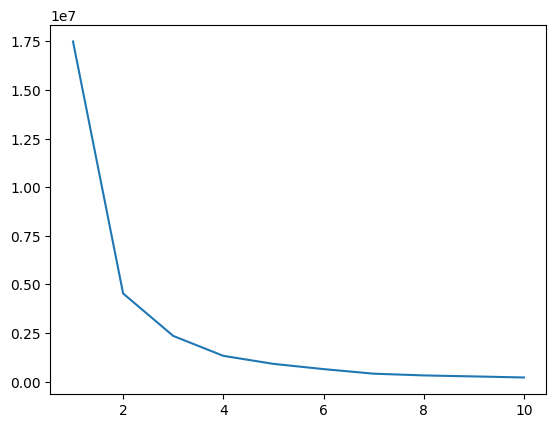

In [10]:
# Metric to see how many clusters to use
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.show()

The results are pretty similar, so let's go ahead with 3 clusters for now.

### Helper Function

Since there are 3 clusters, we can see how our clusters compare to the classes from the dataset. This function will help us map custers to labels by maximizing accuracy. It's the code from week 2's homework, but I modified it to return a dictionary instead of a list. This will make it easier to map the clusters. It also returns the accuracy

In [11]:
def label_permute_compare(ytdf,yp,n=3):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # your code here
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc

### K-Means Clustering

Using 3 clusters, let's cluster our reduced dataset and see how well it performs.

In [12]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X_transformed)

labs, acc = label_permute_compare(y, kmeans.labels_, len(np.unique(y)))
print("Accuracy: ", acc)

Accuracy:  0.7005649717514124


Let us also look at the confusion matrix to see which classes are often confused.

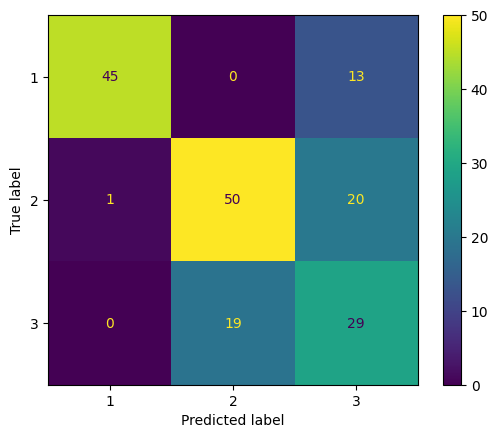

In [13]:
label_maps = [labs[l] for l in kmeans.labels_]
disp = ConfusionMatrixDisplay(confusion_matrix(y, label_maps), display_labels=labs.values())
disp.plot()

It appears that class 3 is confused with classes 1 and 2. There doesn't seem to be much confusion between 1 and 2. Would it have made more sense to have just 2 clusters instead of 3?

Now let's do the same for our full dataset.

Accuracy:  0.7005649717514124


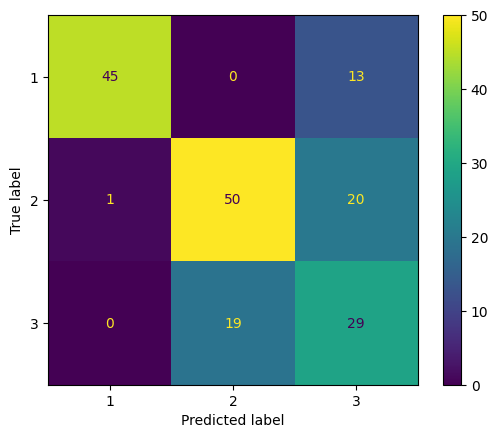

In [14]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)

labs, acc = label_permute_compare(y, kmeans.labels_, len(np.unique(y)))
print("Accuracy: ", acc)

label_maps = [labs[l] for l in kmeans.labels_]
disp = ConfusionMatrixDisplay(confusion_matrix(y, label_maps), display_labels=labs.values())
disp.plot()

The results seem to be the same for the full and reduced dataset. The PCA step may have done a good job reducing the dimensions, but it's too early to tell. Let us try with other models too.

### Hierarchical Clustering (with hyperparameter tuning)

I'm attempting to see how well this model performs for all hyperparameters for the metrics and linkages. Rather than specifying a distance threshold, I'm choosing 3 clusters for this model too. Since the size of the dataset is small, time complexity isn't too much of an issue. It'll be more important when dealing with bigger datasets.

Here are the results for the reduced dataset.

In [15]:
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

par_acc = []

for linkage in linkages:
    # Since ward linkage only supports euclidian metric
    if linkage == "ward":
        model = AgglomerativeClustering(n_clusters=3,metric="euclidean",linkage=linkage).fit(X_transformed)
        labs, acc = label_permute_compare(y,model.labels_,len(np.unique(y)))
        par_acc.append(["ward", "euclidean", acc])
    # For other linkages, try all metrics
    else:
        for metric in metrics:
            model = AgglomerativeClustering(n_clusters=3,metric=metric,linkage=linkage).fit(X_transformed)
            labs, acc = label_permute_compare(y,model.labels_,len(np.unique(y)))
            par_acc.append([linkage, metric, acc])

pd.DataFrame(par_acc, columns=['Linkage', 'Metric', 'Accuracy'])

,Linkage,Metric,Accuracy
0,ward,euclidean,0.559322
1,complete,euclidean,0.677966
2,complete,l1,0.677966
3,complete,l2,0.677966
4,complete,manhattan,0.677966
5,complete,cosine,0.689266
6,average,euclidean,0.542373
7,average,l1,0.542373
8,average,l2,0.542373
9,average,manhattan,0.542373


It appears the best performance is given by the cosine metric, regardless of the linkage type. None of the hyperparameters give us performance as good as k-means clustering though.

Let us see if this is the same for the full dataset.

In [16]:
par_acc = []

for linkage in linkages:
    # Since ward linkage only supports euclidian metric
    if linkage == "ward":
        model = AgglomerativeClustering(n_clusters=3,metric="euclidean",linkage=linkage).fit(X)
        labs, acc = label_permute_compare(y,model.labels_,len(np.unique(y)))
        par_acc.append(["ward", "euclidean", acc])
    # For other linkages, try all metrics
    else:
        for metric in metrics:
            model = AgglomerativeClustering(n_clusters=3,metric=metric,linkage=linkage).fit(X)
            labs, acc = label_permute_compare(y,model.labels_,len(np.unique(y)))
            par_acc.append([linkage, metric, acc])

pd.DataFrame(par_acc, columns=['Linkage', 'Metric', 'Accuracy'])

,Linkage,Metric,Accuracy
0,ward,euclidean,0.694915
1,complete,euclidean,0.672316
2,complete,l1,0.672316
3,complete,l2,0.672316
4,complete,manhattan,0.672316
5,complete,cosine,0.559322
6,average,euclidean,0.610169
7,average,l1,0.548023
8,average,l2,0.610169
9,average,manhattan,0.548023


For this method, it looks like the performance is different for the reduced and full dataset.

The best accuracy in this case seems to be for the ward linkage. It still doesn't perform as well as k-means clustering.

## Comparison with Supervised Models

Here are the supervised models covered in the previous course that I'm using to test this data with. Let us see if our unsupervised models performed nicely in comparison.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = []

# Add the models and their names
models.append(("Logistic Regression:",LogisticRegression()))
models.append(("K-Nearest Neighbour:",KNeighborsClassifier()))
models.append(("Decision Tree:",DecisionTreeClassifier()))
models.append(("Support Vector Machine-linear:",SVC(kernel="linear")))
models.append(("Support Vector Machine-rbf:",SVC(kernel="rbf")))
models.append(("Random Forest:",RandomForestClassifier()))
models.append(("AdaBoostClassifier:",AdaBoostClassifier()))
models.append(("GradientBoostingClassifier:",GradientBoostingClassifier()))

Now that we have set up the models, let's see how they perform on the transformed dataset.

In [18]:
# Check the accuracy score for each model
for name,model in models:
    cv_result = cross_val_score(model, X_transformed, y)
    print(name, cv_result.mean())

Logistic Regression: 0.7014285714285714
K-Nearest Neighbour: 0.672063492063492
Decision Tree: 0.6777777777777778
Support Vector Machine-linear: 0.6671428571428571
Support Vector Machine-rbf: 0.7066666666666667
Random Forest: 0.6777777777777778
AdaBoostClassifier: 0.5769841269841269
GradientBoostingClassifier: 0.6777777777777778


Now for the full dataset.

In [19]:
# Check the accuracy score for each model
for name,model in models:
    cv_result = cross_val_score(model, X, y)
    print(name, cv_result.mean())

Logistic Regression: 0.9553968253968254
K-Nearest Neighbour: 0.6836507936507937
Decision Tree: 0.8817460317460316
Support Vector Machine-linear: 0.9552380952380952
Support Vector Machine-rbf: 0.6446031746031746
Random Forest: 0.9833333333333332
AdaBoostClassifier: 0.7565079365079365
GradientBoostingClassifier: 0.9214285714285714


## Conclusion

Here are the results for every model that was tested on the transformed and full dataset.

|Model|Accuracy (Full Dataset)|Accuracy (Reduced Dimensions)|
|:----|:--------:|:--------:|
|K-Means Clustering|0.7005649717514124|0.7005649717514124|
|Hierarchical Clustering|**0.694915**|0.689266|
|Logistic Regression|**0.9553968253968254**|0.7014285714285714|
|K-Nearest Neighbour|**0.6836507936507937**|0.672063492063492|
|Decision Tree|**0.8817460317460316**|0.6777777777777778|
|Support Vector Machine-linear|**0.9552380952380952**|0.6671428571428571|
|Support Vector Machine-rbf|0.6446031746031746|**0.7066666666666667**|
|Random Forest|**0.9833333333333332**|0.6777777777777778|
|AdaBoostClassifier|**0.7565079365079365**|0.5769841269841269|
|GradientBoostingClassifier|**0.9214285714285714**|0.6777777777777778|

Here is what we can conclude.
* For unsupervised methods, PCA seems to do a good job since the reduced dataset performs as well as the full dataset. This is not the case for all supervised models though. Half of them perform significantly better with the full dataset.
* For the full dataset, the supervised models generaly peform better. The actual performance depends on the model but there's a significant difference for some of them. For the reduced dataset, unsupervised methods perform better than most supervised ones.

I can think of multiple reasons why the PCA didn't work for supervised models. One possible reason is that I used just one component. This may have captured the highest variance, but gotten rid of some of the relationships between individual features and the classes. One possible way to fix this is to use more components in the PCA step. Another thing that can be done is to manually remove features that I don't think are important or are corellated with other features.

## References
* Aeberhard,Stefan and Forina,M.. (1991). Wine. UCI Machine Learning Repository. https://doi.org/10.24432/C5PC7J.